### Импорт библиотек

In [25]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

In [26]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
print(np.__version__)

import keras
print(keras.__version__)

import matplotlib
from matplotlib import pyplot as plt
print(matplotlib.__version__)

2.10.0-dev20220515
1.22.3
2.10.0
3.5.2


In [27]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Создание датасета

In [4]:
TARGET_SHAPE = (280, 280)  # Размер выходной картинки
TARGET_TRAIN_SIZE = 1000 # Размер сгенерированного датасета для обучения
TARGET_TEST_SIZE = 100 # Размер сгенерированного датасета для обучения
MIN_SCALE_FACTOR = 2 # Минимальный коэффицент сжатия
MAX_SCALE_FACTOR = 4 # Максимальный коэффицент сжатия
MIN_LIGHT_FACTOR = 0 # Минимальный коэффицент яркости
MAX_LIGHT_FACTOR = 0.4 # Максимальный коэффицент яркости
MIN_ROTATE_ARG = -25 # Минимальный градус поворота
MAX_ROTATE_ARG = 25 # Максимальный градус поврота
MIN_NUM_DIGITS_PER_IMAGE = 0 # Минимальное кол-во чисел в выходной картинки
MAX_NUM_DIGITS_PER_IMAGE = 10 # Максимальное кол-во чисел в выходной картинки 
MAX_IOU = 0.1 # Максимальный коэфицент покрытия

In [5]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

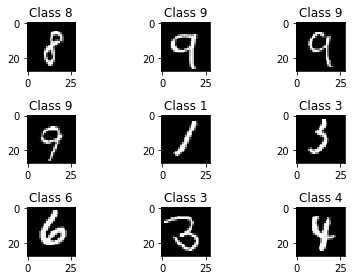

In [6]:
plt.rcParams['figure.figsize'] = (5,5) # Make the figures a bit bigger
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

(280, 280)


<AxesSubplot:>

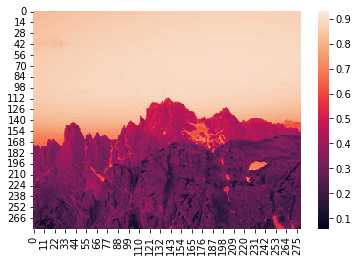

In [10]:
from PIL import Image
import seaborn as sns
img = Image.open('./backgrounds/1.jpg').convert('L')
array = np.array(img) / 255
print(array.shape)
sns.heatmap(array)

In [28]:
from segmentation_dataset_generator import create_semantic_segmentation_data_from_digits
from PIL import Image

LIGHT_COEF = 10
BG_START_INDEX = 0
BG_END_INDEX = 50

def add_noise_to_dataset(input_data):
    new_dataset = []
    for index, i in enumerate(input_data):
        if index % 100 == 0:
            print(index)
        new_dataset.append(add_noise_background(i))
    return np.array(new_dataset)

def add_noise_background(input_data):
    array = np.random.uniform(low=0.3, high=1, size=input_data.shape)
    # index = np.random.randint(BG_START_INDEX, BG_END_INDEX)
    # img = Image.open(f'./backgrounds/{index}.jpg').convert('L')
    # array = np.array(img) / 255
    array =  np.reshape(array, input_data.shape)
    tmp = input_data
    
    tmp[tmp == 0] = LIGHT_COEF
    tmp = tmp / tmp.max() 
    tmp[tmp == 1] = array[tmp == 1]
    return tmp

def transformation(input_element):
    min_scale_factor = MIN_SCALE_FACTOR
    max_scale_factor = MAX_SCALE_FACTOR
    min_rotate_arg = MIN_ROTATE_ARG
    max_rotate_arg = MAX_ROTATE_ARG
    x = input_element.reshape((input_element.shape[0], input_element.shape[1]))
    new_size = (np.random.uniform(low=min_scale_factor, high=max_scale_factor) * np.array(x.shape)).astype(int)
    new_array = np.array(Image.fromarray(x).resize(size=new_size).rotate(np.random.uniform(low=min_rotate_arg, high=max_rotate_arg)))
    new_array = new_array / new_array.max()
    tmp = new_array
    tmp[tmp > 0] = tmp[tmp > 0] + np.random.uniform(low=MIN_LIGHT_FACTOR*LIGHT_COEF, high=MAX_LIGHT_FACTOR*LIGHT_COEF)
    new_array = tmp
    return new_array.reshape((new_array.shape[0], new_array.shape[1], 1))

def generate_dataset(X_test, y_test, num):
    X_test_reshaped = X_test.reshape((len(X_test), 28, 28, 1))
    input_data, target_data, overlaids, labels = create_semantic_segmentation_data_from_digits(
        digits=X_test_reshaped, 
        digit_labels=y_test,
        num_samples=num, 
        image_shape=TARGET_SHAPE,
        min_num_digits_per_image=MIN_NUM_DIGITS_PER_IMAGE,
        max_num_digits_per_image=MAX_NUM_DIGITS_PER_IMAGE,
        num_classes=10, 
        max_iou=MAX_IOU,
        labels_are_exclusive=False,
        target_is_whole_bounding_box=False,
        transformation=transformation,
    )
    input_data = add_noise_to_dataset(input_data)
    return input_data, target_data

In [29]:
X_seg_train, y_seg_train = generate_dataset(X_train, y_train, TARGET_TRAIN_SIZE)
BG_START_INDEX = 51
BG_END_INDEX = 100 
X_seg_test, y_seg_test = generate_dataset(X_test, y_test, TARGET_TEST_SIZE)

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
0


In [30]:
def colorize_target(target):
    colors = np.array([
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [0, 1, 3],
        [1, 2, 3],
        [1, 3, 2],
        [2, 1, 3],
        [2, 3, 1],
        [3, 1, 2],
        [3, 2, 1],
    ]) / 3
    output_array = np.zeros((target.shape[0], target.shape[1], 3))
    for index in range(0,10):
        output_array[target[:,:,index] > 0] = colors[index]
    return output_array

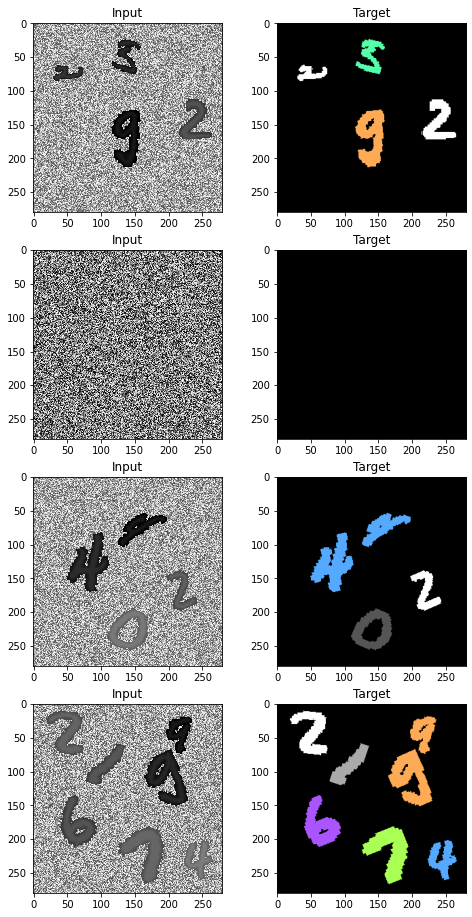

In [31]:
plt.rcParams['figure.figsize'] = (8,16) # Make the figures a bit bigger
for i in range(0, 8, 2):
    plt.subplot(4,2,i+1)
    num = random.randint(0, len(X_seg_test))
    plt.imshow(X_seg_test[num], cmap='gray', interpolation='none')
    plt.title("Input")
    plt.subplot(4,2,i+2)
    plt.imshow(colorize_target(y_seg_test[num]))
    plt.title("Target")

<AxesSubplot:>

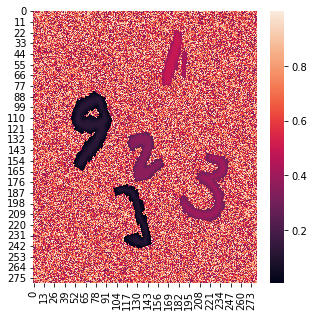

In [32]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (5,5) # Make the figures a bit bigger
sns.heatmap(X_seg_test[0,:,:,0])

In [33]:
# from keras.models import Model
# from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

In [34]:
X_seg_train.shape[1:]

(280, 280, 1)

In [35]:
import tensorflow as tf
from keras import models, layers
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=X_seg_train.shape[1:], padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=y_seg_train.shape[-1], kernel_size=(3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision()])


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 280, 280, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 280, 280, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 140, 140, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 140, 140, 32)      9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 140, 140, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 70, 70, 32)       0         
 2D)                                                    

In [37]:
history = model.fit(X_seg_train, y_seg_train, epochs=50,
                    validation_data=(X_seg_test, y_seg_test))

Epoch 1/50
32/32 [==============================] - 7s 125ms/step - loss: 0.1825 - binary_accuracy: 0.9498 - recall: 0.0405 - precision: 0.0096 - val_loss: 0.0502 - val_binary_accuracy: 0.9889 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 3s 102ms/step - loss: 0.0461 - binary_accuracy: 0.9894 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0402 - val_binary_accuracy: 0.9899 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/50
32/32 [==============================] - 3s 99ms/step - loss: 0.0376 - binary_accuracy: 0.9902 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0341 - val_binary_accuracy: 0.9903 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/50
32/32 [==============================] - 3s 99ms/step - loss: 0.0328 - binary_accuracy: 0.9902 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0320 - val_binary_accuracy: 0.9903 - val_recall: 0.0000e+00 - val_precision: 0.000

In [38]:
test_y_predicted = model.predict(X_seg_test)

4/4 [==============================] - 0s 19ms/step


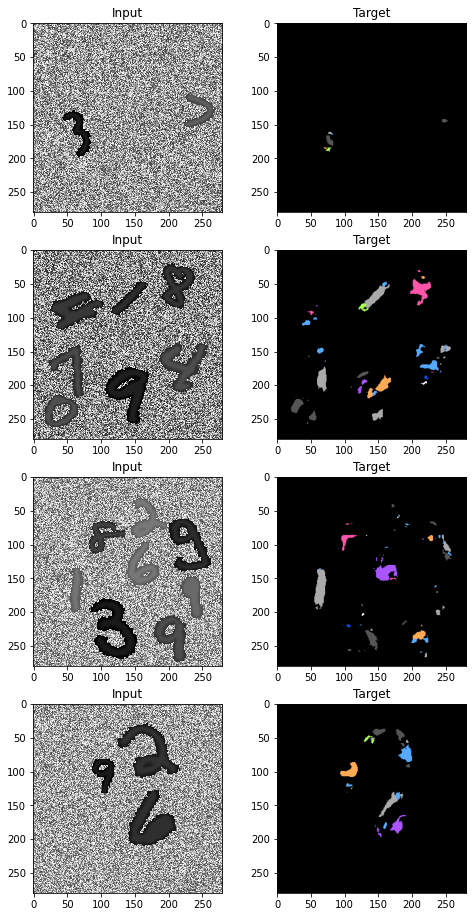

In [39]:
def colorize_target(target):
    colors = np.array([
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [0, 1, 3],
        [1, 2, 3],
        [1, 3, 2],
        [2, 1, 3],
        [2, 3, 1],
        [3, 1, 2],
        [3, 2, 1],
    ]) / 3
    output_array = np.zeros((target.shape[0], target.shape[1], 3))
    for index in range(0,10):
        output_array[target[:,:,index] > 0.5] = colors[index]
    return output_array

plt.rcParams['figure.figsize'] = (8,16) # Make the figures a bit bigger
for i in range(0, 8, 2):
    plt.subplot(4,2,i+1)
    num = np.random.randint(0, len(X_seg_test))
    plt.imshow(X_seg_test[num], cmap='gray', interpolation='none')
    plt.title("Input")
    plt.subplot(4,2,i+2)
    plt.imshow(colorize_target(test_y_predicted[num]))
    plt.title("Target")